### Modeling with Neural network

In this notebook I trained LSTM model to classify news articles to find that it has high , mixed or low factual data


In [1]:
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from sklearn import utils


from sklearn.utils import shuffle,resample

from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB


from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dense, Input, Embedding, Dropout, Activation, GRU, Flatten,SpatialDropout1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Convolution1D
from keras.layers.convolutional import Conv1D,Conv2D
from keras.models import Model,Sequential
from keras import initializers, constraints, regularizers, optimizers, layers
from keras.callbacks import EarlyStopping
from keras.metrics import categorical_accuracy
from keras.models import load_model


import warnings
warnings.simplefilter(action='ignore')

Using TensorFlow backend.


In [2]:

data_file = './data/news_data.csv'

In [3]:
## Load data into dataframe
news_df = pd.read_csv(data_file)

In [4]:
news_df.head()

,Unnamed: 0,author,country,crawled,domain_rank,facebook_comments,facebook_likes,language,main_image,participants_count,published,rating,site,site_categories,site_type,text,title,url,factual_reporting
0,0,Javier Moreno,US,2019-04-11T07:20:39.028+03:00,137.0,319,382,english,https://img.buzzfeed.com/buzzfeed-static/stati...,1,2019-04-11T12:14:00.000+03:00,NaN,www.buzzfeed.com,"['media', 'homework_study_tips', 'education']",blogs,Questions are coming. HBO Correct Incorrect Co...,"Which ""Game Of Thrones"" Group Do You Really Be...",https://www.buzzfeed.com/javiermoreno/game-of-...,Mixed
1,1,Political Reporter Jackson Gothe-Snape,AU,2019-04-11T07:25:13.024+03:00,1455.0,45,43,english,https://www.abc.net.au/news/image/9226414-16x9...,1,2019-04-11T03:00:00.000+03:00,NaN,www.abc.net.au,"['television', 'music', 'entertainment']",news,Australians are increasingly suspicious of gov...,Election to focus on economy but voters losing...,https://www.abc.net.au/news/2019-04-11/federal...,High
2,2,sports.yahoo.com,US,2019-04-11T07:35:44.051+03:00,137.0,0,0,english,https://img.buzzfeed.com/buzzfeed-static/stati...,1,2019-04-11T03:00:00.000+03:00,NaN,www.buzzfeed.com,"['media', 'homework_study_tips', 'education']",news,Share On facebook Share On facebook Compartilh...,Responda estas perguntas sobre sexo e adivinha...,https://www.buzzfeed.com/br/luisdelvalle/respo...,Mixed
3,3,Yoonjung Seo,US,2019-04-11T07:36:28.007+03:00,81.0,3031,24808,english,https://cdn.cnn.com/cnnnext/dam/assets/1904101...,1,2019-04-11T12:19:00.000+03:00,NaN,edition.cnn.com,['media'],news,Seoul (CNN) South Korea's 66-year abortion ban...,Will South Korea legalize abortion after 50-ye...,https://edition.cnn.com/2019/04/11/health/sout...,Mixed
4,4,Caroline Kelly,US,2019-04-11T07:36:45.001+03:00,81.0,5701,20690,english,https://cdn.cnn.com/cnnnext/dam/assets/1603211...,1,2019-04-11T12:24:00.000+03:00,NaN,edition.cnn.com,['media'],news,Washington (CNN) President Donald Trump's olde...,"Investigation into Maryanne Trump Barry, Presi...",https://edition.cnn.com/2019/04/11/politics/ma...,Mixed


In [5]:
news_df.shape

(34680, 19)

### It seems that unnamed is an extra column so we need to drop it and also rating value of each article is not available.So we need to drop both of them

In [6]:
news_df.drop(['Unnamed: 0','rating'],axis=1,inplace=True)

In [7]:
news_df.shape

(34680, 17)

In [8]:
#finding the columns having null values and data type is object
null_columns_with_dt_object = [col for col in news_df.columns if (news_df[col].isnull().sum()>0) & (news_df[col].dtype == np.object)]
                #(news_df[col].dtype == np.object)] 
null_columns_with_dt_object

['author', 'country', 'main_image', 'title']

In [9]:
#replacing the null values
for each_column in null_columns_with_dt_object:
    news_df[each_column].fillna('NA',inplace=True)
    

In [10]:
#replacing the null values for domain rank
news_df['domain_rank'].fillna(0,inplace=True)


In [11]:
#changing the country code to their corresponsing name
country_encoded_dict = {'US' :  'United States', 'AU' : 'Australia', 'JP' : 'Japan', 'CZ' : 'Czech Repulbic', 'GB' : 'United Kingdom(GB)', 'CA' : 'Canada', 
             'DE' : 'Germany', 'CC' : 'Cocos (Keeling) Islands', 'CH' : 'Switzerland', 'TK' : 'Tokelau', 'ID' :  'Indonesia',
             'BG' :  'Bulgaria','EU':'European Union','PH': 'Philippines','ML': 'Mali','IN':'India','NG':'Nigeria','TR':'Turkey',
            'MA': 'Morocco','LI': 'Liechtenstein','FR':'France','IT':'Italy','NL':'Netherlands','IL':'Israel','NA':'NA'}
news_df['country'] = news_df['country'].map(lambda x: country_encoded_dict[x])

In [12]:
# creating the copy of actual df and from now onwords we will work on this copy
news_df_new = news_df.copy()

### Removing all the duplicate articles

In [13]:
news_df_new.drop_duplicates(subset='title',inplace=True,keep='first')

In [14]:
news_df_new.shape

(26754, 17)

In [15]:
#No. of articles in each category after remoc=ving duplicate articles
news_df_new['factual_reporting'].value_counts()

High     12311
Mixed    12121
Low       2322
Name: factual_reporting, dtype: int64

In [16]:
news_df_new.isnull().sum()

author                0
country               0
crawled               0
domain_rank           0
facebook_comments     0
facebook_likes        0
language              0
main_image            0
participants_count    0
published             0
site                  0
site_categories       0
site_type             0
text                  0
title                 0
url                   0
factual_reporting     0
dtype: int64

### Look at how many articles are there other than English language and drop all those articles

In [17]:
news_df_new['language'].value_counts()

english       24460
arabic          936
spanish         643
japanese        525
portuguese      180
french            3
german            3
chinese           2
indonesian        1
welsh             1
Name: language, dtype: int64

In [18]:
news_df_new.drop(news_df_new[news_df_new['language'] != 'english'].index,inplace=True)
news_df_new.shape

(24460, 17)

In [19]:
# No of articles in each category after removing all non-english articles
news_df_new['factual_reporting'].value_counts()

High     12306
Mixed     9833
Low       2321
Name: factual_reporting, dtype: int64

In [20]:
#Minimum and maximum published date in data set
print("Minimum published date:", news_df_new['published'].min())
print("Maximum published date:", news_df_new['published'].max())


Minimum published date: 2019-04-10T02:29:00.000+03:00
Maximum published date: 2019-05-11T12:28:00.000+03:00


In [21]:
#baseline
news_df_new['factual_reporting'].value_counts(normalize=True)

High     0.503107
Mixed    0.402003
Low      0.094890
Name: factual_reporting, dtype: float64

In [22]:
## Preprocessing the articles to convert article text into numerical data
lemmatizer = WordNetLemmatizer()
custom_stop_words = ['correct','incorrect']
stop_words = stopwords.words("english")
stop_words.extend(custom_stop_words)

def preprocess_article(article_text):
    article_text = re.sub(r'[^\w\s]','',article_text, re.UNICODE)
    article_text = article_text.lower()
    article_text = [lemmatizer.lemmatize(token) for token in article_text.split(" ")]
    article_text = [lemmatizer.lemmatize(token) for token in article_text]
    article_text = [word for word in article_text if not word in stop_words]
    article_text = " ".join(article_text)
    #print(article_text)
    return article_text

In [23]:
news_df_new['processed_articles'] = news_df_new['text'].apply(lambda x: preprocess_article(x))

In [24]:
df_processed_article = news_df_new[['processed_articles','text','factual_reporting']];

In [25]:
df_processed_article['processed_articles'].apply(lambda x: len(x.split(" "))).mean()


353.61860179885525

### Working with nueral networks

In [26]:
# Creating the vocabulary from the article text. The maximum number of words to be used are specified in MAX_NB_WORDS. (most frequent)
#MAX_NB_WORDS = 20000
MAX_NB_WORDS = 2000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_processed_article['processed_articles'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 180802 unique tokens.


In [27]:
#convert it sequence for computation
#generating sparse matrix from the word tokens
X = tokenizer.texts_to_sequences(df_processed_article['processed_articles'].values)
# Max number of words in each article
#MAX_SEQUENCE_LENGTH = 250
MAX_SEQUENCE_LENGTH = 350
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [28]:
X.shape

(24460, 350)

In [29]:
y = pd.get_dummies(df_processed_article['factual_reporting'].values)

In [30]:
y.shape

(24460, 3)

In [31]:
X.shape

(24460, 350)

In [32]:
y.shape

(24460, 3)

In [33]:
## Creating train test split for LSTM model
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 43)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(16388, 350) (16388, 3)
(8072, 350) (8072, 3)


### Modeling data

In [35]:
## Neural network with embedding layer and LSTM
embed_size=130
#generating sequential nueral network
model = Sequential()
#specifyting the input layer of word embedding
model.add(Embedding(MAX_NB_WORDS,embed_size,input_length=X.shape[1]))
#specifying the dropout layer so model won't overfit
model.add(SpatialDropout1D(0.2))
#specifying LSTM layer
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
#specifying the output layer(3 repesents the number class in which you want to classifiy and activation methon is Softmax because we
#need to find the probability of the words)
model.add(Dense(3,activation='softmax'))
#compiling the model(we put categorical cross entropy becase of multiclass classification and we are looking for improving 
#model accuracy that's why the metrics is 'accuracy')
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 350, 130)          260000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 350, 130)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               92400     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 352,703
Trainable params: 352,703
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
batch_size=64
epochs = 5
#fitting the model and running 5 epochs with batch size of 64
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.33,\
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

#we specified Earlystopping so when model is not improving on accuracy it stops and Patience=3 indicates that it will wait for
#3 iteration for its improvement and still accuracy is not improved than model will stop iterating on epochs

Train on 10979 samples, validate on 5409 samples
Epoch 1/5
10979/10979 [==============================] - ETA: 6:06 - loss: 1.1018 - acc: 0.218 - ETA: 4:15 - loss: 1.0996 - acc: 0.281 - ETA: 3:40 - loss: 1.0968 - acc: 0.343 - ETA: 3:19 - loss: 1.0939 - acc: 0.378 - ETA: 3:08 - loss: 1.0905 - acc: 0.421 - ETA: 3:08 - loss: 1.0871 - acc: 0.455 - ETA: 3:08 - loss: 1.0833 - acc: 0.479 - ETA: 3:03 - loss: 1.0800 - acc: 0.494 - ETA: 2:58 - loss: 1.0748 - acc: 0.508 - ETA: 2:53 - loss: 1.0714 - acc: 0.515 - ETA: 2:50 - loss: 1.0678 - acc: 0.519 - ETA: 2:46 - loss: 1.0612 - acc: 0.529 - ETA: 2:43 - loss: 1.0531 - acc: 0.538 - ETA: 2:41 - loss: 1.0464 - acc: 0.540 - ETA: 2:38 - loss: 1.0320 - acc: 0.547 - ETA: 2:36 - loss: 1.0301 - acc: 0.551 - ETA: 2:33 - loss: 1.0360 - acc: 0.546 - ETA: 2:31 - loss: 1.0381 - acc: 0.539 - ETA: 2:29 - loss: 1.0306 - acc: 0.544 - ETA: 2:27 - loss: 1.0289 - acc: 0.546 - ETA: 2:26 - loss: 1.0198 - acc: 0.550 - ETA: 2:24 - loss: 1.0133 - acc: 0.554 - ETA: 2:24 - lo

10979/10979 [==============================] - ETA: 2:53 - loss: 0.5175 - acc: 0.796 - ETA: 2:55 - loss: 0.3726 - acc: 0.859 - ETA: 2:57 - loss: 0.3453 - acc: 0.875 - ETA: 2:55 - loss: 0.3254 - acc: 0.878 - ETA: 2:54 - loss: 0.3408 - acc: 0.875 - ETA: 2:53 - loss: 0.3510 - acc: 0.875 - ETA: 2:52 - loss: 0.3362 - acc: 0.886 - ETA: 2:51 - loss: 0.3287 - acc: 0.888 - ETA: 2:51 - loss: 0.3229 - acc: 0.890 - ETA: 2:50 - loss: 0.3101 - acc: 0.898 - ETA: 2:49 - loss: 0.3083 - acc: 0.899 - ETA: 2:49 - loss: 0.3004 - acc: 0.902 - ETA: 2:49 - loss: 0.3038 - acc: 0.901 - ETA: 2:48 - loss: 0.2981 - acc: 0.905 - ETA: 2:47 - loss: 0.3079 - acc: 0.904 - ETA: 2:46 - loss: 0.3241 - acc: 0.895 - ETA: 2:45 - loss: 0.3386 - acc: 0.888 - ETA: 2:44 - loss: 0.3411 - acc: 0.887 - ETA: 2:43 - loss: 0.3418 - acc: 0.887 - ETA: 2:42 - loss: 0.3456 - acc: 0.885 - ETA: 2:41 - loss: 0.3470 - acc: 0.883 - ETA: 2:40 - loss: 0.3442 - acc: 0.882 - ETA: 2:39 - loss: 0.3405 - acc: 0.883 - ETA: 2:38 - loss: 0.3428 - acc: 0

10979/10979 [==============================] - ETA: 2:52 - loss: 0.1884 - acc: 0.953 - ETA: 2:50 - loss: 0.1862 - acc: 0.945 - ETA: 2:50 - loss: 0.2285 - acc: 0.927 - ETA: 3:02 - loss: 0.2648 - acc: 0.914 - ETA: 3:01 - loss: 0.2514 - acc: 0.918 - ETA: 2:58 - loss: 0.2574 - acc: 0.916 - ETA: 2:57 - loss: 0.2487 - acc: 0.921 - ETA: 2:57 - loss: 0.2526 - acc: 0.919 - ETA: 2:55 - loss: 0.2482 - acc: 0.923 - ETA: 2:54 - loss: 0.2397 - acc: 0.929 - ETA: 2:53 - loss: 0.2439 - acc: 0.929 - ETA: 2:51 - loss: 0.2415 - acc: 0.929 - ETA: 2:50 - loss: 0.2471 - acc: 0.925 - ETA: 2:49 - loss: 0.2557 - acc: 0.923 - ETA: 2:48 - loss: 0.2549 - acc: 0.924 - ETA: 2:46 - loss: 0.2561 - acc: 0.924 - ETA: 2:45 - loss: 0.2535 - acc: 0.925 - ETA: 2:43 - loss: 0.2580 - acc: 0.924 - ETA: 2:42 - loss: 0.2575 - acc: 0.923 - ETA: 2:41 - loss: 0.2563 - acc: 0.924 - ETA: 2:40 - loss: 0.2506 - acc: 0.924 - ETA: 2:39 - loss: 0.2463 - acc: 0.926 - ETA: 2:38 - loss: 0.2409 - acc: 0.928 - ETA: 2:37 - loss: 0.2400 - acc: 0

In [37]:
#evaluating the accuracy on text data
accr = model.evaluate(X_test,y_test)
accr

8072/8072 [==============================] - ETA: 34 - ETA: 34 - ETA: 30 - ETA: 29 - ETA: 27 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 

[0.34018459217576724, 0.8868929633300298]

In [38]:
y_pred = model.predict(X_test)

In [39]:
y_pred = pd.DataFrame(y_pred).apply(np.round)

In [40]:
y_test2 = y_test.idxmax(axis=1)

In [41]:
y_pred.columns = ['High','Low','Mixed']

In [42]:
y_pred2 = y_pred.idxmax(axis=1)

In [55]:
def genrate_classificatoin_report(y_test,y_pred):
    print(classification_report(y_test,y_pred))

In [44]:
genrate_classificatoin_report(y_test2,y_pred2)

              precision    recall  f1-score   support

        High       0.92      0.89      0.91      4090
         Low       0.73      0.67      0.70       757
       Mixed       0.88      0.93      0.91      3225

    accuracy                           0.89      8072
   macro avg       0.85      0.83      0.84      8072
weighted avg       0.89      0.89      0.89      8072



In [56]:
def generate_confusion_matrix(y_test,y_pred):
    class_names=['High','Low','Mixed'] 
    cnf_matrix = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots()

    sns.heatmap(pd.DataFrame(cnf_matrix,columns=['High','Low','Medium'],index=['High','Low','Medium']), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

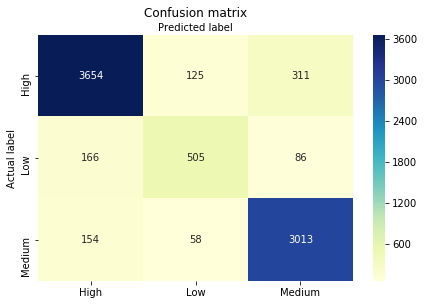

In [46]:
generate_confusion_matrix(y_test2,y_pred2)

### Nueral nework with Bidirectional LSTM and including 1 dimensional Convolutional network

In [47]:
embed_size=130
model = Sequential()
model.add(Embedding(MAX_NB_WORDS,embed_size,input_length=X.shape[1]))
#provided Conv1D layer to identify aomplex pattern in text to get meaning out of it
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
#pool size is provided to reduce the dimentions
model.add(MaxPooling1D(pool_size=2))
#Bidirectional LSTM layer is specified so model will work on both original and reversed vectors
model.add(Bidirectional(LSTM(100,dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 350, 130)          260000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 350, 32)           12512     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 175, 32)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               106400    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 603       
Total params: 379,515
Trainable params: 379,515
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
batch_size=64
epochs = 5
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.33,\
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 10979 samples, validate on 5409 samples
Epoch 1/5
10979/10979 [==============================] - ETA: 14:39 - loss: 1.0971 - acc: 0.35 - ETA: 9:40 - loss: 1.0906 - acc: 0.4141 - ETA: 8:03 - loss: 1.0840 - acc: 0.442 - ETA: 7:12 - loss: 1.0776 - acc: 0.476 - ETA: 6:36 - loss: 1.0697 - acc: 0.496 - ETA: 6:14 - loss: 1.0599 - acc: 0.492 - ETA: 5:58 - loss: 1.0541 - acc: 0.482 - ETA: 5:46 - loss: 1.0475 - acc: 0.478 - ETA: 5:37 - loss: 1.0333 - acc: 0.491 - ETA: 5:29 - loss: 1.0201 - acc: 0.506 - ETA: 5:22 - loss: 1.0190 - acc: 0.505 - ETA: 5:15 - loss: 1.0238 - acc: 0.496 - ETA: 5:09 - loss: 1.0180 - acc: 0.498 - ETA: 5:03 - loss: 1.0160 - acc: 0.493 - ETA: 4:58 - loss: 1.0158 - acc: 0.493 - ETA: 4:53 - loss: 1.0068 - acc: 0.498 - ETA: 4:49 - loss: 0.9989 - acc: 0.508 - ETA: 4:45 - loss: 0.9920 - acc: 0.515 - ETA: 4:42 - loss: 0.9855 - acc: 0.521 - ETA: 4:41 - loss: 0.9787 - acc: 0.523 - ETA: 4:38 - loss: 0.9751 - acc: 0.528 - ETA: 4:35 - loss: 0.9734 - acc: 0.527 - ETA: 4:33 - l

10979/10979 [==============================] - ETA: 4:30 - loss: 0.3888 - acc: 0.906 - ETA: 4:43 - loss: 0.3522 - acc: 0.882 - ETA: 4:47 - loss: 0.3518 - acc: 0.895 - ETA: 4:51 - loss: 0.3260 - acc: 0.898 - ETA: 4:48 - loss: 0.3358 - acc: 0.900 - ETA: 4:47 - loss: 0.3301 - acc: 0.898 - ETA: 4:45 - loss: 0.3149 - acc: 0.901 - ETA: 4:41 - loss: 0.3033 - acc: 0.902 - ETA: 4:38 - loss: 0.2967 - acc: 0.906 - ETA: 4:38 - loss: 0.2975 - acc: 0.903 - ETA: 4:37 - loss: 0.2966 - acc: 0.903 - ETA: 4:36 - loss: 0.2997 - acc: 0.902 - ETA: 4:34 - loss: 0.2961 - acc: 0.902 - ETA: 4:31 - loss: 0.3036 - acc: 0.899 - ETA: 4:30 - loss: 0.3066 - acc: 0.900 - ETA: 4:27 - loss: 0.3096 - acc: 0.899 - ETA: 4:26 - loss: 0.3028 - acc: 0.901 - ETA: 4:24 - loss: 0.2975 - acc: 0.902 - ETA: 4:22 - loss: 0.2927 - acc: 0.903 - ETA: 4:22 - loss: 0.2934 - acc: 0.904 - ETA: 4:20 - loss: 0.2932 - acc: 0.905 - ETA: 4:19 - loss: 0.2994 - acc: 0.903 - ETA: 4:17 - loss: 0.2946 - acc: 0.905 - ETA: 4:16 - loss: 0.2963 - acc: 0

10979/10979 [==============================] - ETA: 4:54 - loss: 0.1596 - acc: 0.953 - ETA: 5:01 - loss: 0.1794 - acc: 0.960 - ETA: 5:01 - loss: 0.1862 - acc: 0.953 - ETA: 4:59 - loss: 0.2039 - acc: 0.941 - ETA: 4:49 - loss: 0.1893 - acc: 0.943 - ETA: 4:49 - loss: 0.1824 - acc: 0.945 - ETA: 4:54 - loss: 0.1994 - acc: 0.939 - ETA: 4:49 - loss: 0.2090 - acc: 0.931 - ETA: 4:50 - loss: 0.2123 - acc: 0.930 - ETA: 4:47 - loss: 0.2173 - acc: 0.928 - ETA: 4:45 - loss: 0.2092 - acc: 0.933 - ETA: 4:42 - loss: 0.2152 - acc: 0.932 - ETA: 4:40 - loss: 0.2094 - acc: 0.933 - ETA: 4:39 - loss: 0.2103 - acc: 0.934 - ETA: 4:38 - loss: 0.2010 - acc: 0.937 - ETA: 4:36 - loss: 0.2010 - acc: 0.937 - ETA: 4:33 - loss: 0.2009 - acc: 0.934 - ETA: 4:32 - loss: 0.2025 - acc: 0.932 - ETA: 4:29 - loss: 0.1995 - acc: 0.932 - ETA: 4:27 - loss: 0.2036 - acc: 0.928 - ETA: 4:26 - loss: 0.2041 - acc: 0.926 - ETA: 4:23 - loss: 0.1991 - acc: 0.929 - ETA: 4:22 - loss: 0.1987 - acc: 0.928 - ETA: 4:22 - loss: 0.1988 - acc: 0

In [49]:
accr = model.evaluate(X_test,y_test)
accr

8072/8072 [==============================] - ETA: 27 - ETA: 28 - ETA: 25 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 

[0.25054557839310676, 0.908201189296333]

In [50]:
#predicted = model.predict(X_test,batch_size=64)
y_pred = model.predict(X_test)

In [51]:
y_pred = pd.DataFrame(y_pred).apply(np.round)

In [52]:
#s2 = dummies.idxmax(axis=1)
y_test2 = y_test.idxmax(axis=1)

In [53]:
y_pred.columns = ['High','Low','Mixed']

In [54]:
y_pred2 = y_pred.idxmax(axis=1)

In [55]:
genrate_classificatoin_report(y_test2,y_pred2)

              precision    recall  f1-score   support

        High       0.91      0.95      0.93      4090
         Low       0.72      0.65      0.69       757
       Mixed       0.95      0.91      0.93      3225

    accuracy                           0.91      8072
   macro avg       0.86      0.84      0.85      8072
weighted avg       0.91      0.91      0.91      8072



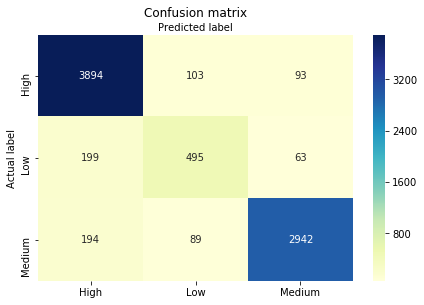

In [56]:
generate_confusion_matrix(y_test2,y_pred2)

### Neural network with 2 bidirectional LSTM layers 1 dimentional convulutional layer and embedding layer

In [57]:
embed_size=130
model = Sequential()
model.add(Embedding(MAX_NB_WORDS,embed_size,input_length=X.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(100,dropout=0.2,recurrent_dropout=0.2,return_sequences=True)))
model.add(Bidirectional(LSTM(100,dropout=0.2,recurrent_dropout=0.2)))
#model.add(GlobalMaxPool1D())
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 350, 130)          260000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 350, 32)           12512     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 175, 32)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 175, 200)          106400    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 603       
Total params: 620,315
Trainable params: 620,315
Non-trainable params: 0
_________________________________________________________________
None

In [58]:
batch_size=64
epochs = 5
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.33,\
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 10979 samples, validate on 5409 samples
Epoch 1/5
10979/10979 [==============================] - ETA: 27:32 - loss: 1.1017 - acc: 0.20 - ETA: 19:08 - loss: 1.0935 - acc: 0.36 - ETA: 16:37 - loss: 1.0811 - acc: 0.43 - ETA: 15:09 - loss: 1.0675 - acc: 0.48 - ETA: 14:19 - loss: 1.0508 - acc: 0.50 - ETA: 13:48 - loss: 1.0447 - acc: 0.50 - ETA: 13:18 - loss: 1.0269 - acc: 0.50 - ETA: 12:57 - loss: 1.0146 - acc: 0.51 - ETA: 12:42 - loss: 1.0214 - acc: 0.50 - ETA: 12:33 - loss: 1.0164 - acc: 0.50 - ETA: 12:22 - loss: 0.9963 - acc: 0.51 - ETA: 12:13 - loss: 0.9912 - acc: 0.51 - ETA: 12:06 - loss: 0.9818 - acc: 0.51 - ETA: 11:57 - loss: 0.9860 - acc: 0.52 - ETA: 11:50 - loss: 0.9838 - acc: 0.52 - ETA: 11:43 - loss: 0.9800 - acc: 0.51 - ETA: 11:39 - loss: 0.9780 - acc: 0.51 - ETA: 11:32 - loss: 0.9773 - acc: 0.51 - ETA: 11:28 - loss: 0.9722 - acc: 0.51 - ETA: 11:22 - loss: 0.9695 - acc: 0.51 - ETA: 11:17 - loss: 0.9668 - acc: 0.52 - ETA: 11:11 - loss: 0.9648 - acc: 0.52 - ETA: 11:05 - l

10979/10979 [==============================] - ETA: 12:14 - loss: 0.3224 - acc: 0.85 - ETA: 11:42 - loss: 0.2279 - acc: 0.90 - ETA: 11:27 - loss: 0.2072 - acc: 0.92 - ETA: 11:20 - loss: 0.2135 - acc: 0.91 - ETA: 11:17 - loss: 0.2203 - acc: 0.91 - ETA: 11:15 - loss: 0.2083 - acc: 0.92 - ETA: 11:11 - loss: 0.2094 - acc: 0.92 - ETA: 11:07 - loss: 0.2120 - acc: 0.91 - ETA: 11:04 - loss: 0.2109 - acc: 0.92 - ETA: 11:01 - loss: 0.2072 - acc: 0.92 - ETA: 10:57 - loss: 0.1988 - acc: 0.92 - ETA: 10:51 - loss: 0.1969 - acc: 0.92 - ETA: 10:49 - loss: 0.1987 - acc: 0.92 - ETA: 10:47 - loss: 0.2079 - acc: 0.92 - ETA: 10:44 - loss: 0.2047 - acc: 0.92 - ETA: 10:40 - loss: 0.2058 - acc: 0.92 - ETA: 10:38 - loss: 0.2030 - acc: 0.92 - ETA: 10:32 - loss: 0.2106 - acc: 0.92 - ETA: 10:29 - loss: 0.2127 - acc: 0.92 - ETA: 10:25 - loss: 0.2087 - acc: 0.92 - ETA: 10:21 - loss: 0.2087 - acc: 0.92 - ETA: 10:16 - loss: 0.2130 - acc: 0.92 - ETA: 10:11 - loss: 0.2137 - acc: 0.92 - ETA: 10:06 - loss: 0.2115 - acc: 

10979/10979 [==============================] - ETA: 12:17 - loss: 0.1219 - acc: 0.95 - ETA: 11:50 - loss: 0.1264 - acc: 0.95 - ETA: 11:47 - loss: 0.1701 - acc: 0.95 - ETA: 11:38 - loss: 0.1926 - acc: 0.94 - ETA: 11:29 - loss: 0.1656 - acc: 0.95 - ETA: 11:26 - loss: 0.1551 - acc: 0.95 - ETA: 11:21 - loss: 0.1476 - acc: 0.95 - ETA: 11:16 - loss: 0.1350 - acc: 0.96 - ETA: 11:12 - loss: 0.1340 - acc: 0.95 - ETA: 11:06 - loss: 0.1311 - acc: 0.95 - ETA: 11:06 - loss: 0.1279 - acc: 0.95 - ETA: 11:02 - loss: 0.1267 - acc: 0.95 - ETA: 10:56 - loss: 0.1364 - acc: 0.95 - ETA: 10:53 - loss: 0.1395 - acc: 0.95 - ETA: 10:49 - loss: 0.1332 - acc: 0.95 - ETA: 10:46 - loss: 0.1306 - acc: 0.95 - ETA: 10:40 - loss: 0.1335 - acc: 0.95 - ETA: 10:37 - loss: 0.1385 - acc: 0.95 - ETA: 10:33 - loss: 0.1453 - acc: 0.95 - ETA: 10:28 - loss: 0.1474 - acc: 0.95 - ETA: 10:23 - loss: 0.1469 - acc: 0.95 - ETA: 10:20 - loss: 0.1435 - acc: 0.95 - ETA: 10:15 - loss: 0.1391 - acc: 0.95 - ETA: 10:11 - loss: 0.1388 - acc: 

In [59]:
accr = model.evaluate(X_test,y_test)
accr

8072/8072 [==============================] - ETA: 55 - ETA: 55 - ETA: 59 - ETA: 59 - ETA: 1: - ETA: 59s - ETA: 58 - ETA: 58 - ETA: 58 - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 59 - ETA: 58 - ETA: 57 - ETA: 57 - ETA: 56 - ETA: 56 - ETA: 55 - ETA: 55 - ETA: 54 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 37 - ETA

[0.2157368725174955, 0.9208374628344896]

In [61]:
y_pred = pd.DataFrame(y_pred).apply(np.round)

In [62]:
y_test2 = y_test.idxmax(axis=1)

In [63]:
y_pred.columns = ['High','Low','Mixed']

In [64]:
y_pred2 = y_pred.idxmax(axis=1)

In [65]:
genrate_classificatoin_report(y_test2,y_pred2)

              precision    recall  f1-score   support

        High       0.91      0.95      0.93      4090
         Low       0.72      0.65      0.69       757
       Mixed       0.95      0.91      0.93      3225

    accuracy                           0.91      8072
   macro avg       0.86      0.84      0.85      8072
weighted avg       0.91      0.91      0.91      8072



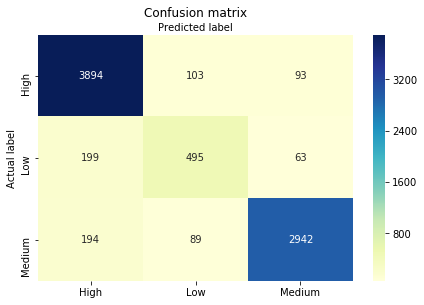

In [66]:
generate_confusion_matrix(y_test2,y_pred2)

### Handling class imbalance
In this part I am handling the clas imbalance because I we have very few articles of Low class so we are upsampling the low class
by resampling it.

In [62]:
def upsample_class(news_data_df):
    df_low = news_data_df[news_data_df['factual_reporting']=='Low']
    df_mixed = news_data_df[news_data_df['factual_reporting']=='Mixed']
    df_high = news_data_df[news_data_df['factual_reporting']=='High']  
    
   

    df_low_upsampled = resample(df_low, 
                                     replace=True,     # sample with replacement
                                     n_samples=9000,    # to match majority class
                                     random_state=47) # reproducible results

    df_news_data_upsampled = pd.concat([df_high,df_mixed,df_low_upsampled])
 
    return df_news_data_upsampled

In [63]:
df_news_data_upsampled = upsample_class(news_df_new)

In [64]:
df_news_data_upsampled.shape

(31139, 18)

In [65]:
lemmatizer = WordNetLemmatizer()
custom_stop_words = ['correct','incorrect']
stop_words = stopwords.words("english")
stop_words.extend(custom_stop_words)

def preprocess_article(article_text):
    article_text = re.sub(r'[^\w\s]','',article_text, re.UNICODE)
    article_text = article_text.lower()
    article_text = [lemmatizer.lemmatize(token) for token in article_text.split(" ")]
    article_text = [lemmatizer.lemmatize(token) for token in article_text]
    article_text = [word for word in article_text if not word in stop_words]
    article_text = " ".join(article_text)
    #print(article_text)
    return article_text

In [66]:
df_news_data_upsampled['processed_articles'] = df_news_data_upsampled['text'].apply(lambda x: preprocess_article(x))

In [67]:
df_upsampled_processed_article = df_news_data_upsampled[['processed_articles','text','factual_reporting']];

In [68]:
df_upsampled_processed_article['processed_articles'].apply(lambda x: len(x.split(" "))).mean()


361.09631009345196

In [69]:
#MAX_NB_WORDS = 20000
MAX_NB_WORDS = 2000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_upsampled_processed_article['processed_articles'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 180543 unique tokens.


In [70]:
#convert it sequence for computation
#list_tokenized_train = tokenizer.texts_to_sequences(df_processed_article['processed_articles'])
X = tokenizer.texts_to_sequences(df_upsampled_processed_article['processed_articles'].values)
# Max number of words in each complaint.
#MAX_SEQUENCE_LENGTH = 250
MAX_SEQUENCE_LENGTH = 350
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [73]:
y=pd.get_dummies(df_upsampled_processed_article['factual_reporting'].values)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 43)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

NameError: name 'train_test_split' is not defined

In [78]:
embed_size=130
model = Sequential()
model.add(Embedding(MAX_NB_WORDS,embed_size,input_length=X.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(100,dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 350, 130)          260000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 350, 32)           12512     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 175, 32)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               106400    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 603       
Total params: 379,515
Trainable params: 379,515
Non-trainable params: 0
_________________________________________________________________
None


In [79]:
batch_size=64
epochs = 5
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.33,\
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 13978 samples, validate on 6885 samples
Epoch 1/5
13056/13978 [===========================>..] - ETA: 18:00 - loss: 1.1018 - acc: 0.21 - ETA: 12:13 - loss: 1.0999 - acc: 0.26 - ETA: 10:15 - loss: 1.0971 - acc: 0.31 - ETA: 9:09 - loss: 1.0957 - acc: 0.3320 - ETA: 8:20 - loss: 1.0958 - acc: 0.337 - ETA: 7:54 - loss: 1.0932 - acc: 0.356 - ETA: 7:33 - loss: 1.0919 - acc: 0.366 - ETA: 7:19 - loss: 1.0958 - acc: 0.349 - ETA: 7:07 - loss: 1.0975 - acc: 0.343 - ETA: 6:56 - loss: 1.0956 - acc: 0.351 - ETA: 6:47 - loss: 1.0932 - acc: 0.360 - ETA: 6:40 - loss: 1.0910 - acc: 0.369 - ETA: 6:33 - loss: 1.0916 - acc: 0.365 - ETA: 6:27 - loss: 1.0892 - acc: 0.371 - ETA: 6:24 - loss: 1.0878 - acc: 0.375 - ETA: 6:20 - loss: 1.0866 - acc: 0.377 - ETA: 6:14 - loss: 1.0842 - acc: 0.383 - ETA: 6:09 - loss: 1.0830 - acc: 0.383 - ETA: 6:05 - loss: 1.0842 - acc: 0.379 - ETA: 6:03 - loss: 1.0835 - acc: 0.378 - ETA: 6:00 - loss: 1.0820 - acc: 0.381 - ETA: 5:56 - loss: 1.0807 - acc: 0.381 - ETA: 5:53 - l

13120/13978 [===========================>..] - ETA: 6:16 - loss: 0.5612 - acc: 0.718 - ETA: 6:13 - loss: 0.4782 - acc: 0.789 - ETA: 6:21 - loss: 0.4308 - acc: 0.833 - ETA: 6:17 - loss: 0.4098 - acc: 0.843 - ETA: 6:14 - loss: 0.4081 - acc: 0.843 - ETA: 6:14 - loss: 0.3931 - acc: 0.849 - ETA: 6:08 - loss: 0.3978 - acc: 0.852 - ETA: 6:05 - loss: 0.4126 - acc: 0.847 - ETA: 6:03 - loss: 0.3941 - acc: 0.857 - ETA: 6:00 - loss: 0.3850 - acc: 0.862 - ETA: 5:58 - loss: 0.3744 - acc: 0.867 - ETA: 5:57 - loss: 0.3707 - acc: 0.868 - ETA: 5:55 - loss: 0.3805 - acc: 0.866 - ETA: 5:52 - loss: 0.3834 - acc: 0.861 - ETA: 5:50 - loss: 0.3800 - acc: 0.861 - ETA: 5:48 - loss: 0.3875 - acc: 0.858 - ETA: 5:45 - loss: 0.3902 - acc: 0.857 - ETA: 5:42 - loss: 0.3968 - acc: 0.854 - ETA: 5:42 - loss: 0.3956 - acc: 0.852 - ETA: 5:40 - loss: 0.3941 - acc: 0.852 - ETA: 5:38 - loss: 0.3929 - acc: 0.852 - ETA: 5:36 - loss: 0.3901 - acc: 0.852 - ETA: 5:35 - loss: 0.3876 - acc: 0.854 - ETA: 5:33 - loss: 0.3880 - acc: 0

13978/13978 [==============================] - ETA: 20s - loss: 0.3398 - acc: 0.87 - ETA: 19s - loss: 0.3405 - acc: 0.87 - ETA: 17s - loss: 0.3399 - acc: 0.87 - ETA: 15s - loss: 0.3399 - acc: 0.87 - ETA: 14s - loss: 0.3403 - acc: 0.87 - ETA: 12s - loss: 0.3406 - acc: 0.87 - ETA: 10s - loss: 0.3408 - acc: 0.87 - ETA: 9s - loss: 0.3407 - acc: 0.8777 - ETA: 7s - loss: 0.3407 - acc: 0.877 - ETA: 5s - loss: 0.3403 - acc: 0.878 - ETA: 4s - loss: 0.3409 - acc: 0.877 - ETA: 2s - loss: 0.3402 - acc: 0.878 - ETA: 0s - loss: 0.3401 - acc: 0.877 - 387s 28ms/step - loss: 0.3398 - acc: 0.8780 - val_loss: 0.3057 - val_acc: 0.8973
Epoch 3/5
13120/13978 [===========================>..] - ETA: 6:16 - loss: 0.2112 - acc: 0.968 - ETA: 6:17 - loss: 0.2424 - acc: 0.937 - ETA: 5:58 - loss: 0.2944 - acc: 0.911 - ETA: 5:58 - loss: 0.2652 - acc: 0.921 - ETA: 5:57 - loss: 0.2711 - acc: 0.912 - ETA: 5:51 - loss: 0.2717 - acc: 0.908 - ETA: 5:50 - loss: 0.2650 - acc: 0.915 - ETA: 5:47 - loss: 0.2635 - acc: 0.916 - 

13120/13978 [===========================>..] - ETA: 5:57 - loss: 0.1767 - acc: 0.953 - ETA: 6:05 - loss: 0.2201 - acc: 0.937 - ETA: 6:08 - loss: 0.2088 - acc: 0.942 - ETA: 5:58 - loss: 0.2357 - acc: 0.933 - ETA: 5:52 - loss: 0.2167 - acc: 0.934 - ETA: 5:47 - loss: 0.2222 - acc: 0.932 - ETA: 5:47 - loss: 0.2122 - acc: 0.933 - ETA: 5:50 - loss: 0.2176 - acc: 0.929 - ETA: 5:45 - loss: 0.2086 - acc: 0.932 - ETA: 5:42 - loss: 0.2073 - acc: 0.929 - ETA: 5:39 - loss: 0.2082 - acc: 0.927 - ETA: 5:38 - loss: 0.2106 - acc: 0.925 - ETA: 5:36 - loss: 0.2123 - acc: 0.924 - ETA: 5:34 - loss: 0.2073 - acc: 0.925 - ETA: 5:35 - loss: 0.2078 - acc: 0.926 - ETA: 5:33 - loss: 0.2049 - acc: 0.928 - ETA: 5:30 - loss: 0.2122 - acc: 0.924 - ETA: 5:30 - loss: 0.2068 - acc: 0.928 - ETA: 5:29 - loss: 0.2077 - acc: 0.927 - ETA: 5:26 - loss: 0.2023 - acc: 0.930 - ETA: 5:25 - loss: 0.2052 - acc: 0.929 - ETA: 5:25 - loss: 0.2086 - acc: 0.927 - ETA: 5:23 - loss: 0.2056 - acc: 0.929 - ETA: 5:22 - loss: 0.2071 - acc: 0

13978/13978 [==============================] - ETA: 20s - loss: 0.2146 - acc: 0.92 - ETA: 19s - loss: 0.2147 - acc: 0.92 - ETA: 17s - loss: 0.2152 - acc: 0.92 - ETA: 15s - loss: 0.2148 - acc: 0.92 - ETA: 14s - loss: 0.2147 - acc: 0.92 - ETA: 12s - loss: 0.2146 - acc: 0.92 - ETA: 10s - loss: 0.2145 - acc: 0.92 - ETA: 9s - loss: 0.2144 - acc: 0.9285 - ETA: 7s - loss: 0.2145 - acc: 0.928 - ETA: 5s - loss: 0.2149 - acc: 0.928 - ETA: 4s - loss: 0.2157 - acc: 0.927 - ETA: 2s - loss: 0.2153 - acc: 0.927 - ETA: 0s - loss: 0.2159 - acc: 0.927 - 385s 28ms/step - loss: 0.2165 - acc: 0.9274 - val_loss: 0.3851 - val_acc: 0.8601
Epoch 5/5
13120/13978 [===========================>..] - ETA: 6:16 - loss: 0.1849 - acc: 0.937 - ETA: 6:03 - loss: 0.2748 - acc: 0.890 - ETA: 6:09 - loss: 0.2569 - acc: 0.906 - ETA: 6:16 - loss: 0.3003 - acc: 0.898 - ETA: 6:06 - loss: 0.2735 - acc: 0.909 - ETA: 6:05 - loss: 0.2776 - acc: 0.914 - ETA: 6:05 - loss: 0.2856 - acc: 0.901 - ETA: 6:02 - loss: 0.2701 - acc: 0.908 - 

In [80]:
accr = model.evaluate(X_test,y_test)
accr

10276/10276 [==============================] - ETA: 26 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 27 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA

[0.23577434107017406, 0.9242896068509148]

In [82]:
y_pred = model.predict(X_test)

In [83]:
y_pred = pd.DataFrame(y_pred).apply(np.round)

In [84]:
y_test2 = y_test.idxmax(axis=1)

In [85]:
y_pred.columns = ['High','Low','Mixed']

In [86]:
y_pred2 = y_pred.idxmax(axis=1)

In [91]:
from collections import Counter
Counter(y_pred2)

Counter({'Low': 3092, 'Mixed': 3164, 'High': 4020})

In [87]:
y_pred2.shape,y_test2.shape

((10276,), (10276,))

In [88]:
genrate_classificatoin_report(y_test2,y_pred2)

              precision    recall  f1-score   support

        High       0.90      0.96      0.93      4139
         Low       0.91      0.95      0.93      2967
       Mixed       0.99      0.85      0.92      3170

    accuracy                           0.92     10276
   macro avg       0.93      0.92      0.92     10276
weighted avg       0.93      0.92      0.92     10276



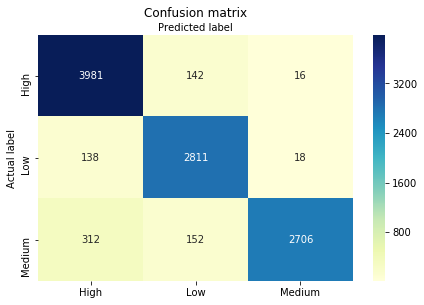

In [89]:
generate_confusion_matrix(y_test2,y_pred2)

In [45]:
embed_size=130
model = Sequential()
model.add(Embedding(MAX_NB_WORDS,embed_size,input_length=X.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(100,dropout=0.2,recurrent_dropout=0.2,return_sequences=True)))
model.add(Bidirectional(LSTM(50,dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(1000, activation='relu'))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 350, 130)          260000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 350, 32)           12512     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 175, 32)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 175, 200)          106400    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100)               100400    
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              101000    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3003      
Total para

In [46]:
batch_size=200
epochs = 5
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.33,\
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 13978 samples, validate on 6885 samples
Epoch 1/5
13978/13978 [==============================] - ETA: 16:07 - loss: 1.0988 - acc: 0.32 - ETA: 12:47 - loss: 1.0990 - acc: 0.32 - ETA: 11:22 - loss: 1.0997 - acc: 0.32 - ETA: 10:42 - loss: 1.0994 - acc: 0.32 - ETA: 10:12 - loss: 1.0986 - acc: 0.33 - ETA: 9:55 - loss: 1.0974 - acc: 0.3500 - ETA: 9:42 - loss: 1.0972 - acc: 0.347 - ETA: 9:38 - loss: 1.0968 - acc: 0.348 - ETA: 9:31 - loss: 1.0952 - acc: 0.355 - ETA: 9:19 - loss: 1.0939 - acc: 0.357 - ETA: 9:08 - loss: 1.0923 - acc: 0.360 - ETA: 8:58 - loss: 1.0873 - acc: 0.372 - ETA: 8:47 - loss: 1.0854 - acc: 0.373 - ETA: 8:37 - loss: 1.0835 - acc: 0.377 - ETA: 8:26 - loss: 1.0816 - acc: 0.381 - ETA: 8:16 - loss: 1.0785 - acc: 0.386 - ETA: 8:05 - loss: 1.0757 - acc: 0.388 - ETA: 7:56 - loss: 1.0690 - acc: 0.398 - ETA: 7:48 - loss: 1.0618 - acc: 0.407 - ETA: 7:40 - loss: 1.0570 - acc: 0.413 - ETA: 7:30 - loss: 1.0510 - acc: 0.417 - ETA: 7:20 - loss: 1.0435 - acc: 0.423 - ETA: 7:10 - l

13978/13978 [==============================] - ETA: 10:17 - loss: 0.2247 - acc: 0.92 - ETA: 10:17 - loss: 0.1625 - acc: 0.94 - ETA: 10:09 - loss: 0.1546 - acc: 0.95 - ETA: 10:05 - loss: 0.1555 - acc: 0.95 - ETA: 10:01 - loss: 0.1509 - acc: 0.95 - ETA: 9:51 - loss: 0.1579 - acc: 0.9508 - ETA: 9:43 - loss: 0.1673 - acc: 0.945 - ETA: 9:35 - loss: 0.1671 - acc: 0.946 - ETA: 9:25 - loss: 0.1645 - acc: 0.947 - ETA: 9:16 - loss: 0.1583 - acc: 0.949 - ETA: 9:08 - loss: 0.1537 - acc: 0.950 - ETA: 8:58 - loss: 0.1559 - acc: 0.950 - ETA: 8:50 - loss: 0.1512 - acc: 0.952 - ETA: 8:40 - loss: 0.1531 - acc: 0.951 - ETA: 8:32 - loss: 0.1631 - acc: 0.947 - ETA: 8:23 - loss: 0.1883 - acc: 0.938 - ETA: 8:13 - loss: 0.2029 - acc: 0.931 - ETA: 8:04 - loss: 0.2149 - acc: 0.925 - ETA: 7:55 - loss: 0.2228 - acc: 0.921 - ETA: 7:47 - loss: 0.2252 - acc: 0.920 - ETA: 7:38 - loss: 0.2265 - acc: 0.920 - ETA: 7:29 - loss: 0.2349 - acc: 0.917 - ETA: 7:20 - loss: 0.2413 - acc: 0.913 - ETA: 7:10 - loss: 0.2434 - acc: 

In [47]:
accr = model.evaluate(X_test,y_test)
accr

10276/10276 [==============================] - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 59 - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 59 - ETA: 59 - ETA: 59 - ETA: 59 - ETA: 59 - ETA: 58 - ETA: 58 - ETA: 58 - ETA: 57 - ETA: 57 - ETA: 57 - ETA: 57 - ETA: 56 - ETA: 56 - ETA: 56 - ETA: 56 - ETA: 55 - ETA: 55 - ETA: 55 - ETA: 54 - ETA: 54 - ETA: 54 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 53 - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 52 - ETA: 52 - ETA: 52 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - E

[0.24665559241283538, 0.9222460101206695]

In [48]:
model.save('news_classification')

In [49]:
y_pred = model.predict(X_test)

In [50]:
y_pred = pd.DataFrame(y_pred).apply(np.round)

In [51]:
y_test2 = y_test.idxmax(axis=1)

In [52]:
y_pred.columns = ['High','Low','Mixed']

In [53]:
y_pred2 = y_pred.idxmax(axis=1)

In [57]:
genrate_classificatoin_report(y_test2,y_pred2)

              precision    recall  f1-score   support

        High       0.94      0.91      0.92      4139
         Low       0.92      0.93      0.93      2967
       Mixed       0.91      0.93      0.92      3170

    accuracy                           0.92     10276
   macro avg       0.92      0.92      0.92     10276
weighted avg       0.92      0.92      0.92     10276



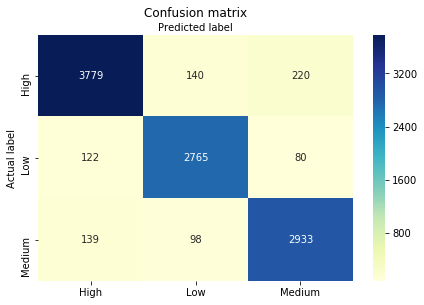

In [58]:
generate_confusion_matrix(y_test2,y_pred2)